<a href="https://colab.research.google.com/github/shashidharjavaji/Machine-Learning/blob/master/IBM_earthquake_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install  kaggle
!pip install catboost

In [0]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [0]:

#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 28.0MB/s]
 95% 229M/242M [00:02<00:00, 100MB/s] 
100% 242M/242M [00:02<00:00, 98.6MB/s]
100% 2.02G/2.03G [00:36<00:00, 53.7MB/s]
100% 2.03G/2.03G [00:36<00:00, 59.5MB/s]


In [0]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

In [0]:
train_df = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [0]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:6000000 cols:2


In [0]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744
9,3,1.4690999733


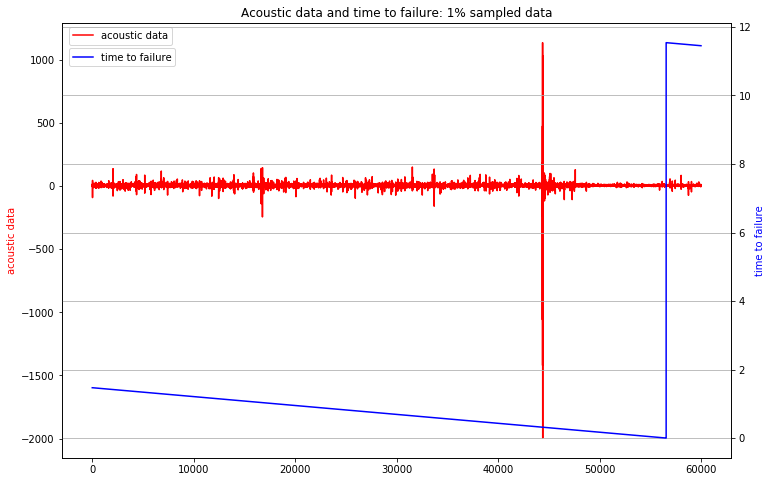

In [0]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

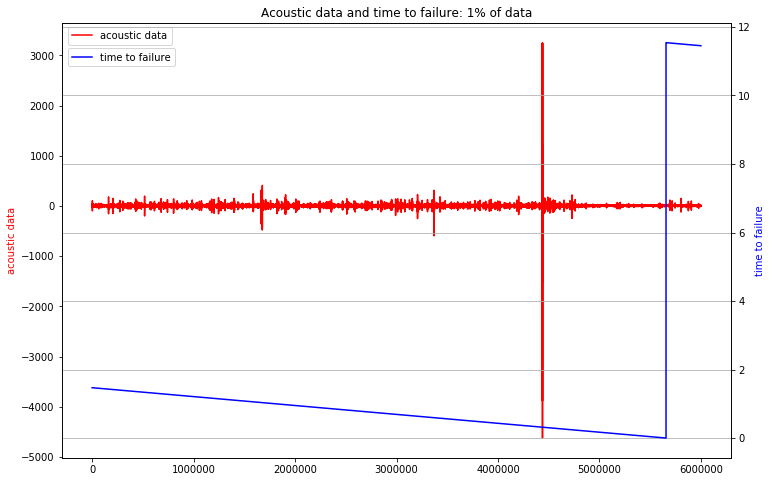

In [0]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

In [0]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  40


In [0]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [0]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [0]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [0]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [0]:
train_X.shape

(40, 154)

In [0]:
train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,Rmean_last_15000,Rstd_last_15000,Rmax_last_15000,Rmin_last_15000,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,12.000000000000004,2349.811481800189085,732617.0,-20121.154171234855312,-1.067140450080236e-15,1399.854635310395224,23432.719432718040480,-23432.719432718044118,-2.606182613213170,1513.574807585783219,9208.972085564804729,-12837.254225910464811,5.354098198492068,2812.202696607881990,21205.810957063822570,-20121.154171234855312,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,3.664663420228340,11.207151110947080,4.361406519310332,4.96210,4.62046,5.1820,4.6756,-98.0,-21.0,-98.0,-16.0,104.0,30.0,104.0,26.0,...,2.302633538390867,2.475638882952861,8.195903140156636,16.948796924021416,-0.000005235445272,74759.569448178153834,52.335254741797996,4.883863549942963,0.452293846429352,10.039999999999999,1.040000000000000,3.81,4.16,5.58,5.95,-0.000002401601067,74760.051283355249325,10.039999999999999,4.288590310584312,2.769772407044410,31.029445007242035,2.536632710012617,2.616094025058814,2.706473905472144,8.185756324653649,15.055998242663405,-0.000011795500483,74223.575745018068119,31.029445007242035,4.883418265649225,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,4.999999999999998,2566.032248433366476,708865.0,-31056.675076437579264,7.033425693710645e-16,1810.312265881220810,27236.180586073751329,-27236.180586073754966,-0.199454239122083,2551.400329629872431,11606.563754897386389,-11771.116138276469428,9.627270104536805,3786.205511080561791,28750.538465475812700,-31056.675076437579264,0.000000000000000,74891.736231905975728,181.0,0.0,7.305232697765033,5.493070500263983,3.976750132226240,3.667890126734739,4.69840,4.78834,4.7772,4.9144,-154.0,-115.0,-23.0,-24.0,181.0,111.0,29.0,29.0,...,2.300285445615412,2.475965274474054,9.829922366802840,23.457270415662862,-0.000000487196303,74801.961652516256436,87.972617410995625,4.725623311385514,0.496219791758936,16.670000000000002,-4.090000000000000,3.64,4.05,5.39,5.75,-0.000000733822548,74800.114701938757207,16.670000000000002,4.843485536157157,4.492905296027906,38.643217286378224,2.509452799586506,2.612481781957736,2.674879245681564,10.544981537946606,33.704331798479267,-0.000000230972610,74363.664079629437765,38.643217286378224,4.724876383379978,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002449664430,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,5.000000000000000,2683.549049300198476,735959.0,-27654.557067499525147,-1.261165986458461e-15,1921.220575571685686,30073.497066171181359,-30073.497066171177721,45.078552149036327,2832.190519067848072,16806.749666036223061,-15992.574637120493207,-4

In [0]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [0]:
scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,Rmean_last_15000,Rstd_last_15000,Rmax_last_15000,Rmin_last_15000,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.737032044660945,-0.223851678289967,-0.244402603315109,0.221233028513214,1.604105067055029,-0.191021990159224,1.737032044660944,0.229765591336065,-0.421983464006836,-0.223766631936069,-0.206610966437645,0.206610966437645,-0.207013303104783,-0.229352169039170,-0.266755768277263,0.204616944293296,0.407921048438539,-0.225822813437327,-0.210720916145967,0.229765591336065,-2.207278332164256,-0.979430797329876,-0.237083930364360,0.0,-0.021824961872928,-0.858640271527284,1.277038860294905,-0.366858159540875,1.895759382925859,0.351204797964263,2.603875974571148,0.430905300280287,-0.057118971464246,1.574301235040907,-1.194666665983171,0.649331304587324,-0.006217757632817,-1.575471565387146,1.047451321173123,-0.626115170511733,...,-0.226425427534621,-0.193571225940299,-0.361888390974835,-0.234849772104867,-0.339202520032120,-0.815654119086726,-0.221881318933485,1.735686385788644,-0.181034189686273,-0.189067376073312,0.235430620235403,0.256104419367635,0.880814317316009,0.674139888813563,-0.092445276285805,-0.549082643157154,-0.796300819342496,-0.189067376073312,-0.274363423654587,-0.225554719272904,-0.186320387151981,-0.033357710330159,-0.235768727740249,-0.116458855346670,-0.472538483918910,-0.232178102720703,-0.266523827003180,-1.171306737115358,-0.186320387151981,1.730949167607187,0.015555902029551,-0.123578892696939,0.222111617246691,0.276913858970295,0.930216737382944,1.273480715028230,0.373289023894734,-0.442389015349655,-1.176263533769781,-0.123578892696939
1,0.924355861022088,-0.151623485135752,-0.087217383392257,0.142006492323030,0.065922126043357,-0.151816050176192,0.924355861022087,0.086478908263361,0.374391856658836,-0.150988442377137,-0.159823381724822,0.159823381724822,-0.101777470040547,-0.158792170959829,-0.223156372497166,0.223786426442720,0.655203695029289,-0.148877764511887,-0.121165281811643,0.086478908263361,0.046963368769452,-0.650081228471923,-0.127687899574513,0.0,0.211048579310884,-0.237044436086219,-0.621615351332651,-0.609974719944680,0.732369015689111,1.157498972080371,0.886995056055836,1.430057485806997,-0.823265654577487,-0.686727276706156,0.638581414809419,0.453491514325360,1.190700586684428,0.250182179911263,-0.702188970318731,-0.549914541240528,...,-0.262042634450746,-0.189639774082587,-0.198825499036983,-0.174321585278734,-0.011221539503124,-0.619386640648897,-0.102844037353258,0.923742548940423,-0.161239623083076,-0.101551155706701,0.141776845281339,0.216668050443271,0.616449856457179,0.228233609006506,-0.145997934525229,-0.049007376165205,-0.610453008394337,-0.101551155706701,-0.151667275864792,-0.141155531980929,-0.150562571914108,-0.444448943383831,-0.289723182028037,-0.484655480891168,-0.243343829547903,-0.09

In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [0]:
submission.shape, test_X.shape

((2624, 1), (2624, 154))

In [0]:
!unzip test.zip

Archive:  test.zip
  inflating: seg_430e66.csv          
  inflating: seg_d1a281.csv          
  inflating: seg_05a1b0.csv          
  inflating: seg_f8dd7e.csv          
  inflating: seg_b9bdd7.csv          
  inflating: seg_24c1c9.csv          
  inflating: seg_c5abaa.csv          
  inflating: seg_6262c4.csv          
  inflating: seg_734a88.csv          
  inflating: seg_94a133.csv          
  inflating: seg_d0c280.csv          
  inflating: seg_d36737.csv          
  inflating: seg_f80e44.csv          
  inflating: seg_07c815.csv          
  inflating: seg_7c9433.csv          
  inflating: seg_211486.csv          
  inflating: seg_78ded2.csv          
  inflating: seg_f11f77.csv          
  inflating: seg_b3883e.csv          
  inflating: seg_3db0a8.csv          
  inflating: seg_81f798.csv          
  inflating: seg_0a45a1.csv          
  inflating: seg_dc188b.csv          
  inflating: seg_4a9e8d.csv          
  inflating: seg_32fc4e.csv          
  inflating: seg_7b2994.csv    

In [0]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv(seg_id + '.csv')
    create_features(seg_id, seg, test_X)

In [0]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [0]:
scaled_test_X.shape

(2624, 154)

In [0]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,Rmean_last_15000,Rstd_last_15000,Rmax_last_15000,Rmin_last_15000,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.555825647887208,-0.264471917866126,-0.317891797045273,0.272164373206904,-0.153818294101168,-0.252449516517386,-1.555825647887206,0.282472617488291,-0.160161440774286,-0.263431244028385,-0.248939866372418,0.248939866372418,-0.172531636537682,-0.243100100392885,-0.334484399871000,0.261546412677156,0.387625125655055,-0.273294811865745,-0.293489806374410,0.282472617488291,0.986230744158497,0.039460173159553,-0.288230126577795,0.0,-0.586592037409164,-0.547556552701142,0.250351777140727,-0.709725081509900,-1.406381011724736,-1.385776087256317,-1.052130329184277,-2.176597388246714,0.476447468561046,0.588107948002294,-0.241377663971024,0.404531566759869,-0.627993520914502,-0.718992030555794,0.114309832377468,-0.422913492455187,...,-0.826110885326171,-0.631985322179067,-0.467275887151644,-0.260921037374195,-0.040160057830300,-0.206546163204115,-0.285478879879320,-1.556059552893487,-0.203470023532002,-0.201079406319710,0.237803912778099,0.149394244631121,-0.392941721367443,-0.874797714726737,-0.271846681387875,-0.469070600438442,-0.207414337178696,-0.201079406319710,-0.385371013040467,-0.266474402535175,-0.257309297360494,-0.501299863750636,-0.638098343048151,-0.513262185874054,-0.565766796913451,-0.244449405733568,-1.311965845471383,-0.103713095106731,-0.257309297360494,-1.548859502554671,-0.212886494852398,-0.242570624719531,0.176006364416478,-0.048381301733597,-0.675113883932773,-1.012821075865223,-0.510463362351858,-0.433093908001534,-0.103348467351222,-0.242570624719531
2615,-1.099909929337704,-0.286080049695965,-0.340346828462823,0.299044805128573,0.725143386476930,-0.258725621654231,-1.099909929337704,0.343527076897387,-0.214707695614401,-0.286359737223867,-0.345303538711696,0.345303538711696,-1.789718391099401,-0.257212380300803,-0.331302097084527,0.345172648939499,-0.621454624097821,-0.296238687102078,-0.330068554558960,0.343527076897387,-1.080157481697402,0.550244173097142,-0.303858130976345,0.0,-0.881109244194190,-0.824824618774855,-0.791938597180358,-0.017545645633279,-0.868847897033321,-1.211146255407010,-1.866885330288008,-0.437704388644946,0.763752474728512,1.117284833730330,0.858571184504529,0.061811933801432,-0.907792614391261,-0.966920316954343,-0.818831656418188,0.161291331957384,...,-1.175884644543961,-1.319643894616445,-0.593600701880680,-0.277752164309000,-0.384817538261522,0.466202191495774,-0.308862637940472,-1.097432083796926,-0.210501135717704,-0.228139474457199,0.248392448737818,0.163312963075014,-0.200676658924658,-0.780922708451567,-0.287912478859703,0.571085954904803,0.440788946210801,-0.228139474457199,-0.461780793542161,-0.280120548661365,-0.269793605363461,-1.004039160044659,-1.338923252164864,-1.3419755770995

In [0]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [0]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [0]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[389]	training's l1: 1.21504	valid_1's l1: 1.78513
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.11872	valid_1's l1: 1.6346
[2000]	training's l1: 1.02374	valid_1's l1: 1.50531
Early stopping, best iteration is:
[2320]	training's l1: 1.00273	valid_1's l1: 1.48956
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.57077	valid_1's l1: 0.767237
Early stopping, best iteration is:
[1284]	training's l1: 1.50436	valid_1's l1: 0.761961
fold 3
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 1.81966	valid_1's l1: 1.2403
fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.13198	valid_1's l1: 1.68497
Early stopping, best iteration is:
[1209]	training's l1: 1.11163	valid_1's l1: 1.66959


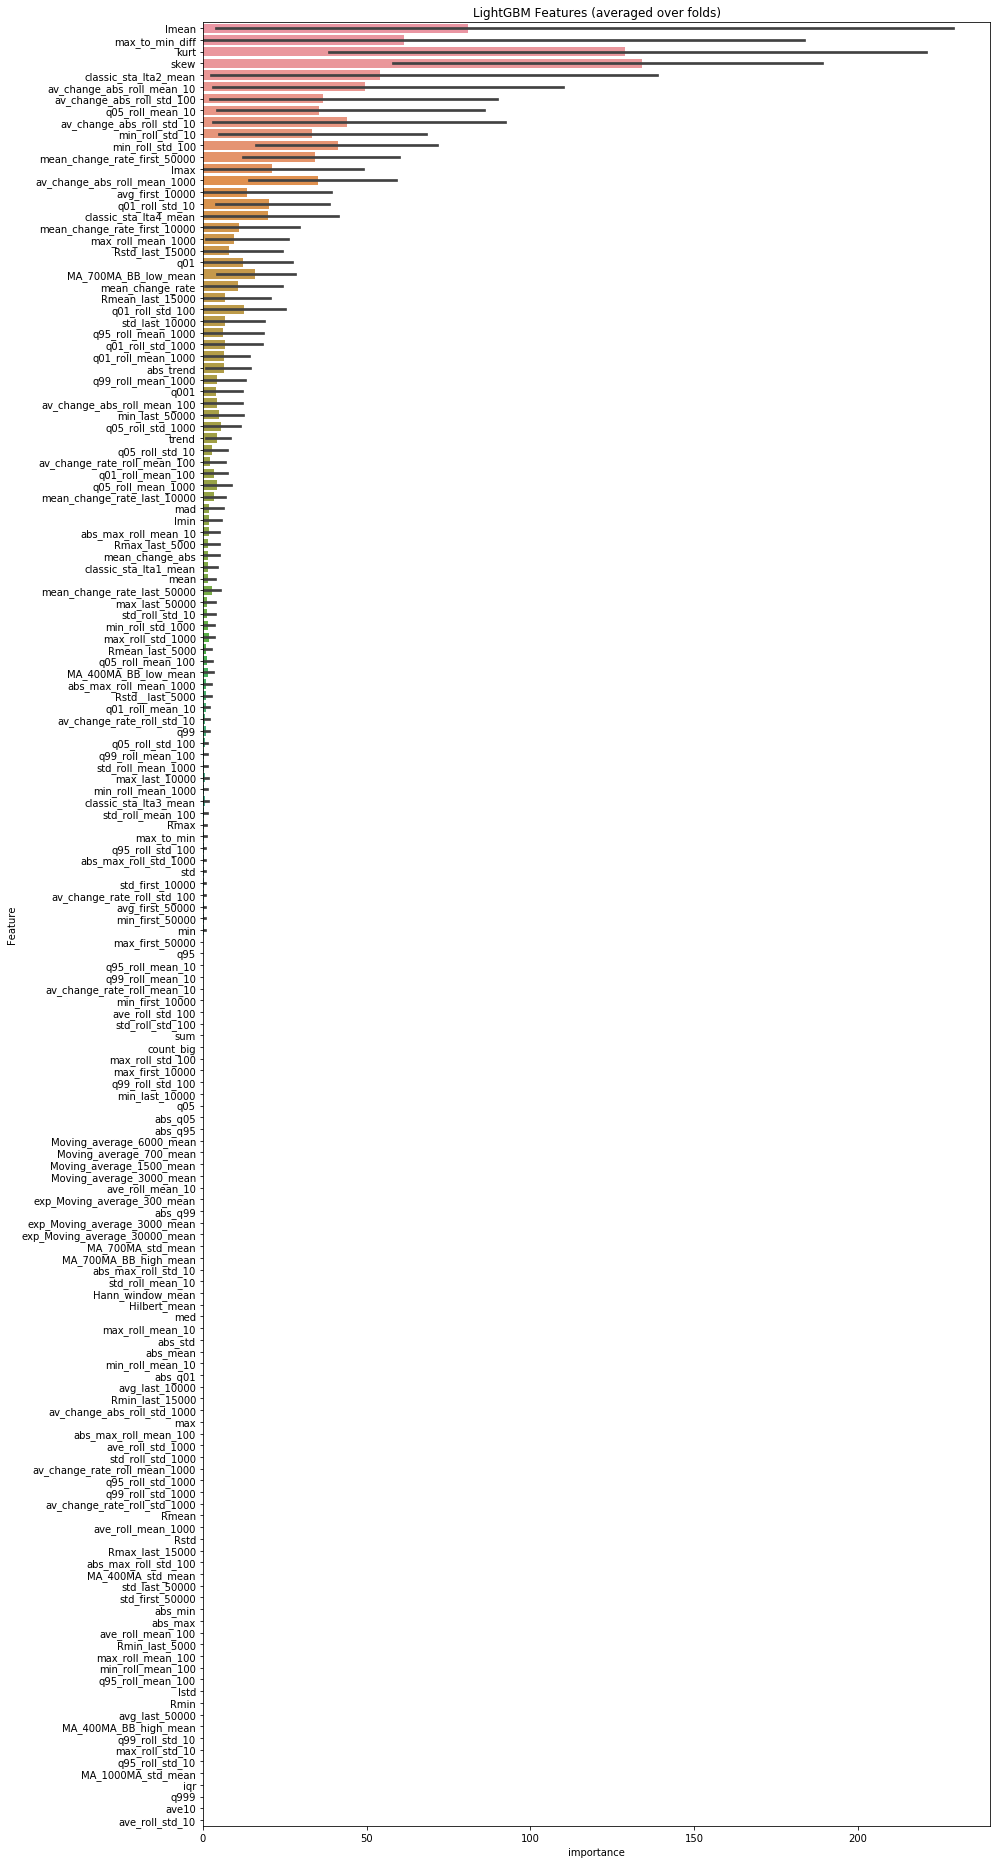

In [0]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [0]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)